In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.svm import SVR, NuSVR
from sklearn.pipeline import make_pipeline

phil = pd.read_csv("../datasets/Philly/DO_QAQC.csv")
phil['DateTime_EST'] = pd.to_datetime(phil['DateTime_EST'])
phil = phil.rename(columns={'DateTime_EST': 'time'}, inplace=False)
print(len(phil))

philweather = pd.read_csv("../datasets/Philly/phillyweather.csv")
philweather['time'] = pd.to_datetime(philweather['time'])
print(len(philweather))

nf =  pd.read_csv("../datasets/Philly/new_features.csv")
nf['time'] = phil['time']

nf.rename(columns={
    'Temp_deg_C^2': 'temperature^2',
    'temperature_2m^2': 'airtemp^2',
    'Temp_2m_interaction': 'temp*airtemp',
    'Depth_Temp_interaction': 'depth*temp',
    'Depth_m': 'Depth',
    'windspeed_10m (km/h)': 'windspeed_10m (km/h)',
    'diffuse_radiation (W/m²)': 'light'
}, inplace=True)

205032
9720


In [16]:
nf = nf.dropna()
X_train, X_test, y_train, y_test = train_test_split(
    nf[['temperature^2', 'airtemp^2', 'temp*airtemp', 'depth*temp', 'Depth', 'windspeed_10m (km/h)', 'light']],
    nf['DO_mg_L'],
    test_size=0.2
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

print("------------ Random Forest Results ------------")
rf = RandomForestRegressor(n_estimators=24, max_depth=40, random_state=0)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
y_pred = rf.predict(X_test)
stats(y_pred, y_test)


print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = DecisionTreeRegressor(max_depth=24, criterion='friedman_mse', splitter='best', random_state=0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ Bagging Results ------------")
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
base_estimator = DecisionTreeRegressor()
bag_pipe = make_pipeline(preprocessing.SplineTransformer(), BaggingRegressor(base_estimator=base_estimator, n_estimators=10, n_jobs=5))
bag_pipe.fit(X_train, y_train)
y_pred = bag_pipe.predict(X_test)
stats(y_pred, y_test)

print("------------ Extra Trees Results ------------")
from sklearn.ensemble import ExtraTreesRegressor
extra_pipe = make_pipeline(preprocessing.SplineTransformer(), ExtraTreesRegressor(n_estimators=10, n_jobs=5))
extra_pipe.fit(X_train, y_train)
y_pred = extra_pipe.predict(X_test)
stats(y_pred, y_test)

print("------------ Ada Boost Results ------------")
from sklearn.ensemble import AdaBoostRegressor
ada_pipe = make_pipeline(preprocessing.SplineTransformer(), AdaBoostRegressor(base_estimator=base_estimator, n_estimators=10))
ada_pipe.fit(X_train, y_train)
y_pred = ada_pipe.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)

import pymysql

# Connect to the database
connection = pymysql.connect(
    host='localhost', 
    user='root', 
    password='N@wid2003', 
    db='dma_iot_morefish_spark_farms_v3'
)

# Create a cursor object
cursor = connection.cursor()

# Get the latest data from the database and store it in a pandas dataframe
query = "SELECT dvd_ph, dvd_temp, dvd_updated_at, dvd_do, dvd_dev_id FROM device_devicedata WHERE dvd_ph > 0 AND dvd_temp > 0 AND dvd_dev_id = 2 ORDER BY dvd_updated_at ASC"
df = pd.read_sql(query, connection)

# Close the connection
connection.close()
len(df)

df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp' }, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])
df.columns

# Add new features: depth, temperature^2, airtemp^2, temp*airtemp, depth*temp

df['Depth'] = 1.2192
df['temperature'] = pd.to_numeric(df['temperature'])
df['temperature^2'] = df['temperature'] * df['temperature']
df['airtemp^2'] = df['airtemp'] * df['airtemp']
df['temp*airtemp'] = df['temperature'] * df['airtemp']
df['depth*temp'] = df['Depth'] * df['temperature']

------------ Random Forest Results ------------
[0.49340448 0.10897236 0.0480239  0.05738335 0.10263859 0.09047813
 0.09909918]
R2 Score: 0.9407
Mean Absolute Error (MAE): 0.43804035973209554
Root Mean Squared Error (RMSE): 0.8616075733789889
------------ Decision Tree Results ------------
R2 Score: 0.8736
Mean Absolute Error (MAE): 0.5035463876078194
Root Mean Squared Error (RMSE): 1.0410288502066567
------------ Bagging Results ------------
R2 Score: 0.9335
Mean Absolute Error (MAE): 0.4628349199602845
Root Mean Squared Error (RMSE): 0.8865910962605732
------------ Extra Trees Results ------------
R2 Score: 0.9620
Mean Absolute Error (MAE): 0.3036657956768946
Root Mean Squared Error (RMSE): 0.770668726358922
------------ Ada Boost Results ------------
R2 Score: 0.9517
Mean Absolute Error (MAE): 0.28130302503479193
Root Mean Squared Error (RMSE): 0.8184680028451842
------------ XG Boost Results ------------
R2 Score: 0.6861
Mean Absolute Error (MAE): 1.2156406915502278
Root Mean Squar

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor


nf = nf.dropna()
X_train, X_test, y_train, y_test = train_test_split(
    nf[['temperature^2', 'airtemp^2', 'temp*airtemp', 'depth*temp', 'Depth', 'windspeed_10m (km/h)', 'light']],
    nf['DO_mg_L'],
    test_size=0.2
)

# Linear Regression
print("------------ Linear Regression Results ------------")
linear_reg = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
stats(y_pred, y_test)

# Bayesian Ridge Regression
print("------------ Bayesian Ridge Regression Results ------------")
bayesian_ridge = make_pipeline(preprocessing.StandardScaler(), BayesianRidge())
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)
stats(y_pred, y_test)

# Huber Regression
print("------------ Huber Regression Results ------------")
huber_reg = make_pipeline(preprocessing.StandardScaler(), HuberRegressor())
huber_reg.fit(X_train, y_train)
y_pred = huber_reg.predict(X_test)
stats(y_pred, y_test)

# K-Nearest Neighbors (KNN)
print("------------ KNN Results ------------")
knn = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor())
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
stats(y_pred, y_test)

# Lasso Regression
print("------------ Lasso Regression Results ------------")
lasso = make_pipeline(preprocessing.StandardScaler(), Lasso())
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
stats(y_pred, y_test)

# Ridge Regression
print("------------ Ridge Regression Results ------------")
ridge = make_pipeline(preprocessing.StandardScaler(), Ridge())
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
stats(y_pred, y_test)

# ElasticNet Regression
print("------------ ElasticNet Regression Results ------------")
elastic_net = make_pipeline(preprocessing.StandardScaler(), ElasticNet())
elastic_net.fit(X_train, y_train)
y_pred = elastic_net.predict(X_test)
stats(y_pred, y_test)

# Isolation Forest
print("------------ Isolation Forest Results ------------")
isolation_forest = make_pipeline(preprocessing.StandardScaler(), IsolationForest())
isolation_forest.fit(X_train, y_train)
y_pred = isolation_forest.predict(X_test)
stats(y_pred, y_test)

# Multi-Layer Perceptron (MLP) Regressor
print("------------ MLP Regressor Results ------------")
mlp_regressor = make_pipeline(preprocessing.StandardScaler(), MLPRegressor())
mlp_regressor.fit(X_train, y_train)
y_pred = mlp_regressor.predict(X_test)
stats(y_pred, y_test)


In [21]:
sf_test = df[['temperature^2', 'airtemp^2', 'temp*airtemp', 'depth*temp', 'Depth', 'windspeed_10m (km/h)', 'light']]
y_pred = extra_pipe.predict(sf_test)
df['do'] = y_pred
df[['do_linreg', 'do']].sample(20)

,do_linreg,do
714,9.272,8.4920
722,9.471,8.4370
297,9.194,12.5250
39,8.769,9.0995
21,8.734,8.9510
339,8.807,7.5580
205,8.418,12.9679
691,9.53,9.1500
653,9.132,11.8040
109,8.522,8.6710


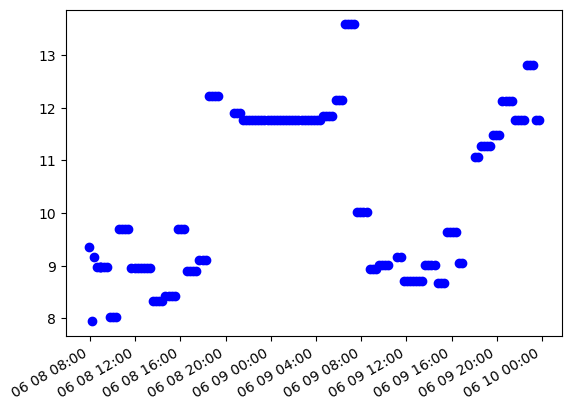

In [22]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

myDates = [datetime(2012,1,i+3) for i in range(10)]
myValues = [5,6,4,3,7,8,1,2,5,4]
fig, ax = plt.subplots()
bet = df.loc[df['datetime'].between('2023-06-08', '2023-06-10')]
ax.plot(bet['datetime'], bet['do'].astype(float), 'bo')

myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()
plt.show()